#### Here again import the necessary lib and the use the database to store the data , but to get the transcripts we use another lib which needs just the video_id (which we already have) and it return the transcripts in an unstructured format. This is for the old links.

In [2]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, VideoUnavailable
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time
import pickle
from collections import defaultdict
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from pymongo import MongoClient
import os
import pandas as pd

In [ ]:
with open('E:\\NLP_Recommender_System\\data\\ted_video_links_2730.pkl', 'rb') as picklefile:
    links_video_ted = pickle.load(picklefile)

In [ ]:
client = MongoClient()
client.list_database_names()
db = client['ted']
db.create_collection("ted_transcript_old")
ted_transcripts = db.get_collection('ted_transcript_old')

In [ ]:
total_videos = len(links_video_ted)
total_videos

2730

In [ ]:
# **Resume from video 2254** (Adjust if needed)
remaining_videos = links_video_ted

def fetch_transcript(video_id):
    try:
        start_time = time.time()
        response = YouTubeTranscriptApi.get_transcript(video_id)
        elapsed_time = time.time() - start_time

        if elapsed_time > 10:  # Timeout condition
            raise TimeoutError("Transcript request took too long")

        ted_transcripts.insert_one({'url': video_id, 'transcript': response})
    except (TranscriptsDisabled, VideoUnavailable, TimeoutError) as e:
        ted_transcripts.insert_one({'url': video_id, 'transcript': f"Error: {str(e)}"})
    except Exception as e:
        ted_transcripts.insert_one({'url': video_id, 'transcript': f"Unknown Error: {str(e)}"})

# **Use threading to speed up the process**
with ThreadPoolExecutor(max_workers=5) as executor:
    list(tqdm(executor.map(fetch_transcript, remaining_videos), total=len(remaining_videos), desc="Fetching Transcripts", unit="video"))

print("✅ Completed transcript extraction!")

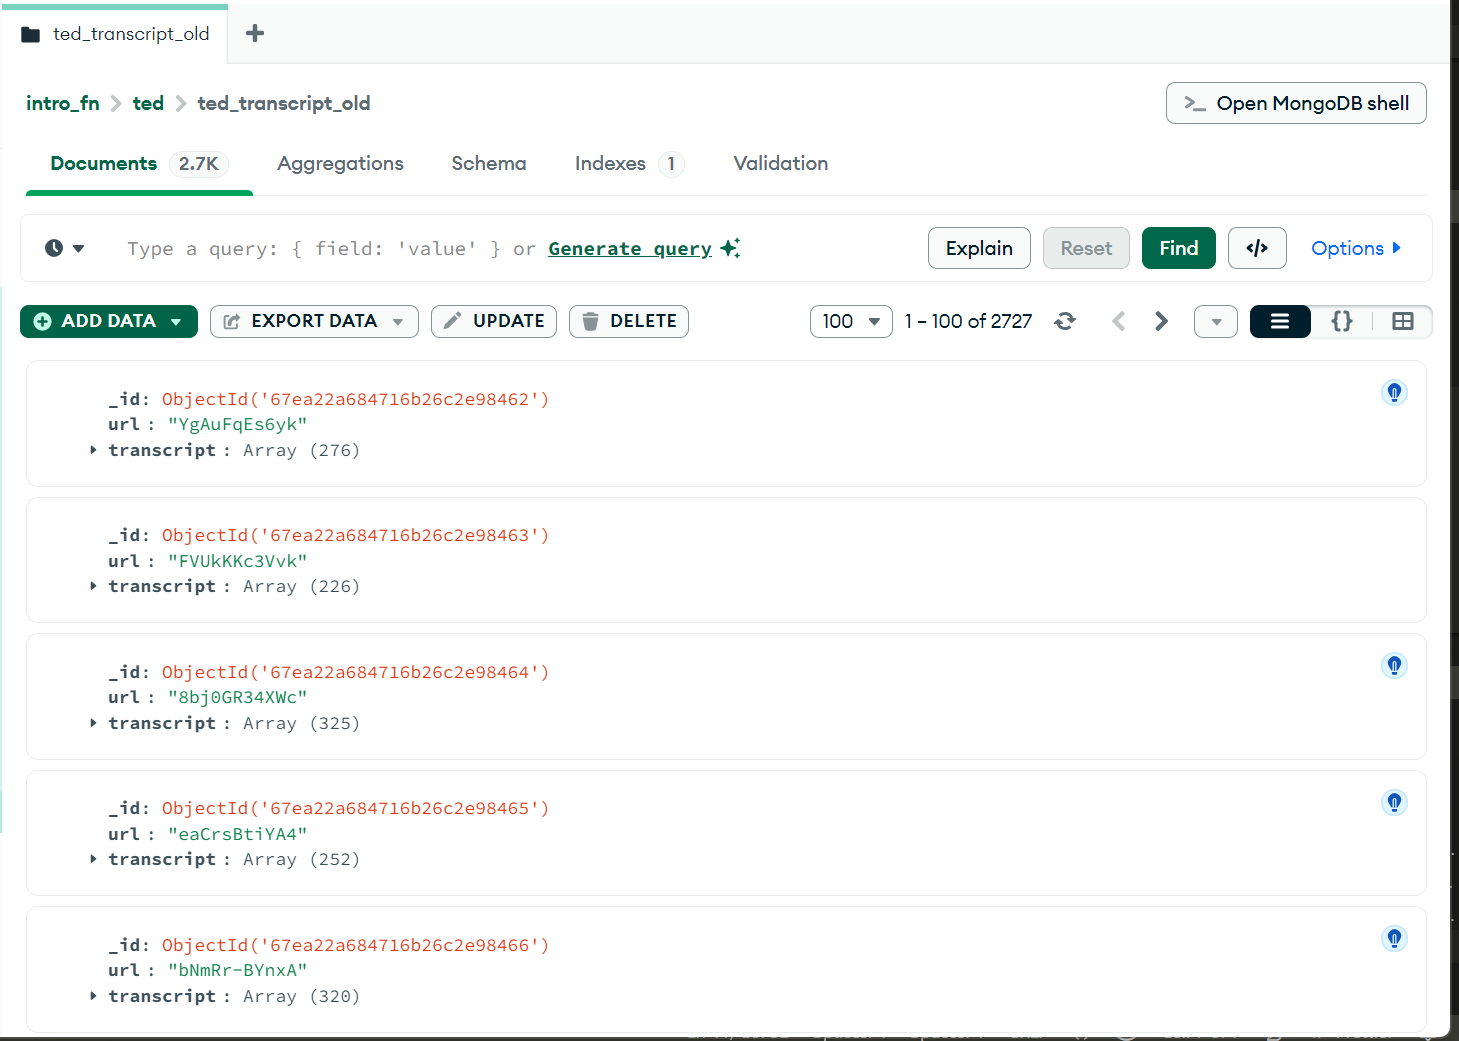